In [46]:
import pandas as pd
import windaq as wdq
import matplotlib.pyplot as plt
from pathlib import Path

In [47]:
import os
from tkinter import Tk, filedialog

def select_folder_and_find_files(extension=".WDH"):
    # Hide the Tkinter root window
    root = Tk()
    root.withdraw()
    
    # Prompt the user to select a folder
    folder_path = filedialog.askdirectory(title="Select a Folder")
    if not folder_path:
        print("No folder selected.")
        return []
    
    # Find and return all files with the given extension
    matching_files = []
    for root_dir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(extension):
                matching_files.append(os.path.join(root_dir, file))
    
    return matching_files

def find_files(folder_path, extension=".WDH"):  
    # Find and return all files with the given extension
    matching_files = []
    for root_dir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(extension):
                matching_files.append(os.path.join(root_dir, file))
    
    return matching_files

In [48]:
def wdh_to_df(file):
    wfile = wdq.windaq(file)
    tdata = wfile.time()
    data = {}
    for ch in range(wfile.nChannels):
        data['ch'] = wfile.data(ch)

    df = pd.DataFrame({ 'time, s':       wfile.time(),
                        'speed, rpm':    wfile.data(3),
                        'torque, Nm':    wfile.data(1),
                        'temp, degF':    wfile.data(2)})
    
    df['torque, Nm'] = df['torque, Nm'] * -1
    return df

In [49]:
def plot_torque_stand_data(df, start_time=0, stop_time=0):
    # Filter the dataframe to only include the specified time chunk
    if stop_time != 0:
        df_plot = df[(df['time, s'] >= start_time) & (df['time, s'] <= stop_time)]
    else:
        df_plot = df

    # Create a figure with three vertically stacked subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

    # Plot the speed data on the first subplot
    ax1.plot(df_plot['time, s'], df_plot['speed, rpm'], label='Speed', color="red")
    ax1.set_ylabel("Speed, rpm", color="red")
    ax1.set_title("Test Data - Speed, Torque, and Temperature over Time")
    ax1.grid(which='major', linestyle='-', linewidth=0.75, alpha=0.7)

    # Plot the torque data on the second subplot
    ax2.plot(df_plot['time, s'], df_plot['torque, Nm'], label='Torque', color="blue")
    ax2.set_ylabel("Torque, Nm", color="blue")
    ax2.grid(which='major', linestyle='-', linewidth=0.75, alpha=0.7)

    # Plot the temperature data on the third subplot
    ax2 = plt.twinx(ax2)
    ax2.plot(df_plot['time, s'], df_plot['temp, degF'], label='Temperature', color="green")
    ax2.set_ylabel("Temperature, degF", color="green")
    ax2.grid(which='major', linestyle='-', linewidth=0.75, alpha=0.7)
    

    # Adjust layout to prevent overlap
    plt.tight_layout()

    return plt


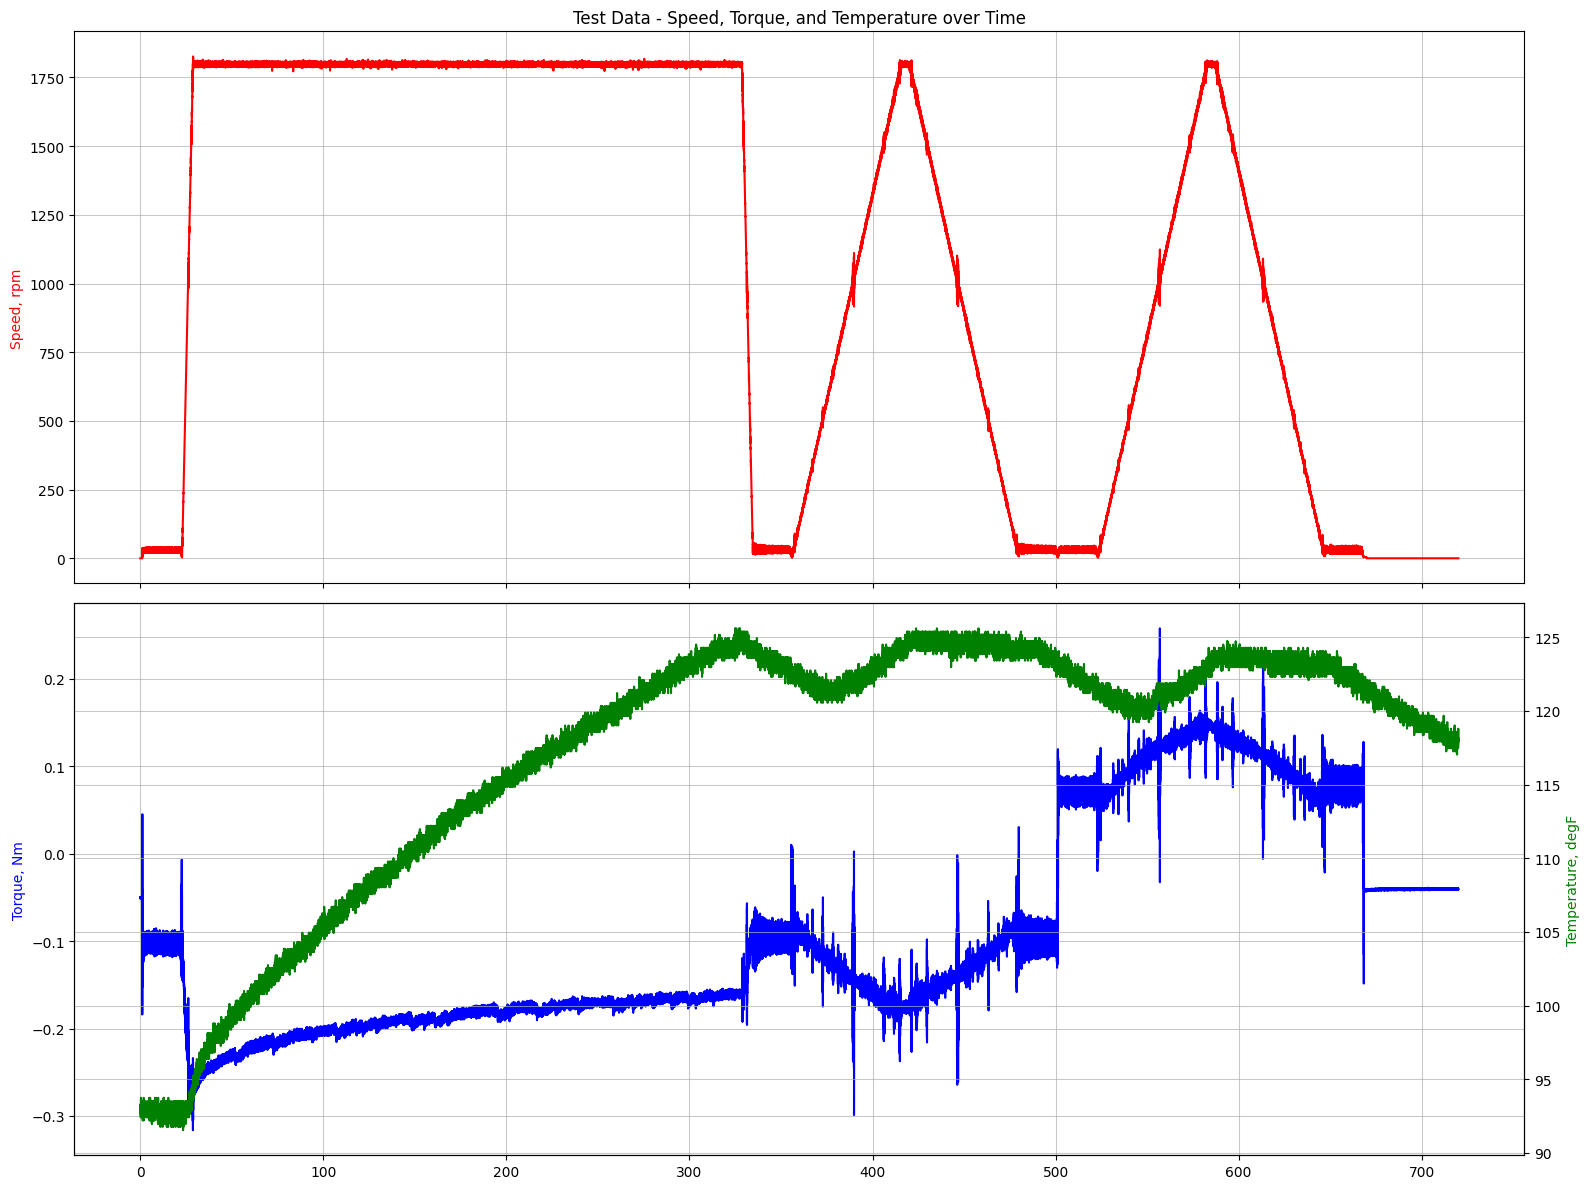

In [50]:
folder = Path("C:\\Users\\Stephen.Garden\\Trelleborg AB\\Private TTC Site - General\\TTC Projects\\Active Projects\\P21995 21996 21997 Torque Testing\\shakedown runs\\data for processing")
file_paths = find_files(folder)
data_files = {}
for i, path in enumerate(file_paths):
    data_files[f'{i}'] = wdh_to_df(path)

for df in data_files:
    plt = plot_torque_stand_data(data_files[df])
    plt.show()
